
https://www.kaggle.com/datasets/ianktoo/simulated-roads-accident-data/  
https://www.kaggle.com/competitions/playground-series-s5e10/data  


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
import seaborn as sns
import shap

train = pd.read_csv('data/train.csv').drop(columns=['id'])
train_small = train.iloc[:int(.1*len(train))]
X_train = train.drop(columns=['accident_risk'])
test = pd.read_csv('data/test.csv')
X_test = test.drop(columns=['id'])
categorical = {'road_type':None, 'lighting':None, 'weather':None, 'time_of_day':None}

for cat in categorical:
    encoder = LabelEncoder()
    X_train[cat] = encoder.fit_transform(X_train[cat])
    X_test[cat] = encoder.transform(X_test[cat])
    categorical[cat] = encoder
y_train = train['accident_risk']



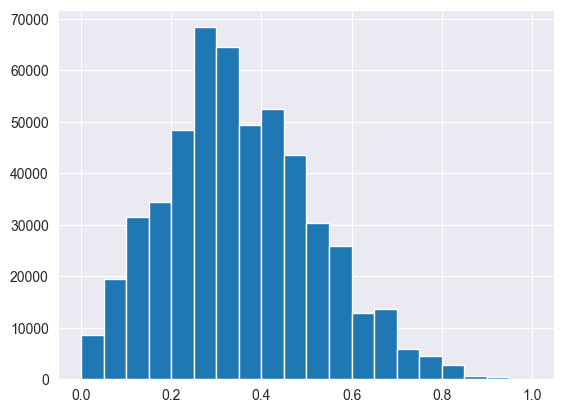

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  int64  
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  int64  
 5   weather                 517754 non-null  int64  
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  int64  
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
dtypes: bool(4), float64(1), int64(7)
memory usage: 33.6 MB


<Axes: >

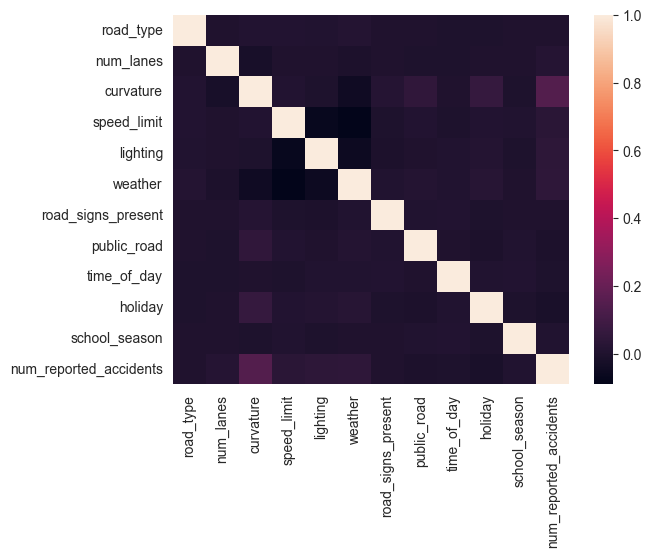

In [9]:
plt.hist(train['accident_risk'], bins=20)
plt.show()
X_train.info()
sns.heatmap(X_train.corr())

In [ ]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# yp = model.predict(X_train)
# 
# acc = np.sqrt(mean_squared_error(y_train, yp))
# print("rmse", acc)

In [3]:
# model = RandomForestRegressor(n_estimators=20)
# model.fit(X_train, y_train)
# yp = model.predict(X_train)
# 
# rmse = np.sqrt(mean_squared_error(y_train, yp))
# print("rmse", rmse)


rmse 0.02491365626477073


In [ ]:
# model = GradientBoostingRegressor(n_estimators=100)
# model.fit(X_train, y_train)
# yp = model.predict(X_train)
# rmse = np.sqrt(mean_squared_error(y_train, yp))
# print("rmse", rmse)

In [5]:
model = XGBRegressor(n_estimators= 400, max_depth=10, learning_rate= 0.05, colsample_bytree= 0.8)
model.fit(X_train, y_train)
yp = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yp))
print("rmse", rmse)

# param_grid = {
#     'n_estimators': [200, 400, 600],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [4, 6, 8],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }
# 
# search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=15, scoring='neg_root_mean_squared_error', n_jobs=-1)
# search.fit(X_train, y_train)
# print(search.best_params_)

#n_estimators= 200, max_depth=8, learning_rate= 0.05, colsample_bytree= 0.8

rmse 0.05270957911178872


In [6]:
test['accident_risk'] = model.predict(X_test)
test[['id','accident_risk']].to_csv('test_pred.csv', index=False)
print("done")

done


| Model / Params                                                              | Train | Test  |
|-----------------------------------------------------------------------------|:-----:|:-----:|
| LinearRegression                                                            | .0885 | .0882 |
| RandomForestRegressor<br/>n_estimators=20                                   | .0249 | .0604 |
| RandomForestRegressor<br/>n_estimators=100                                  | .0231 | .0591 |
| GradientBoostingRegressor<br/>n_estimators=20                               | .0721 |       |
| GradientBoostingRegressor<br/>n_estimators=100                              | .0569 | .0565 |
| XGBRegressor<br/>                                                           | .0555 | .0557 |
| XGBR   n_est=200, max_depth=8, <br/>learning_rate=.05, comsample_bytree=.8  | .0553 | .0556 |
| XGBR   n_est=200, max_depth=10, <br/>learning_rate=.05, comsample_bytree=.8 | .0538 | .0557 |
| XGBR   n_est=200, max_depth=14, <br/>learning_rate=.05, comsample_bytree=.8 | .0437 | .0573 |



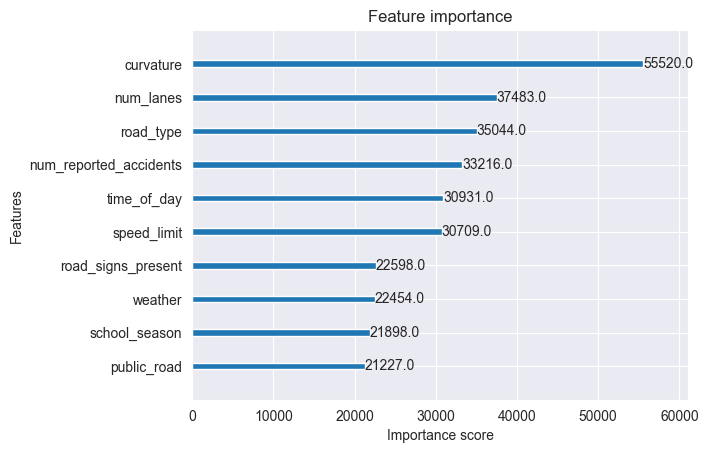

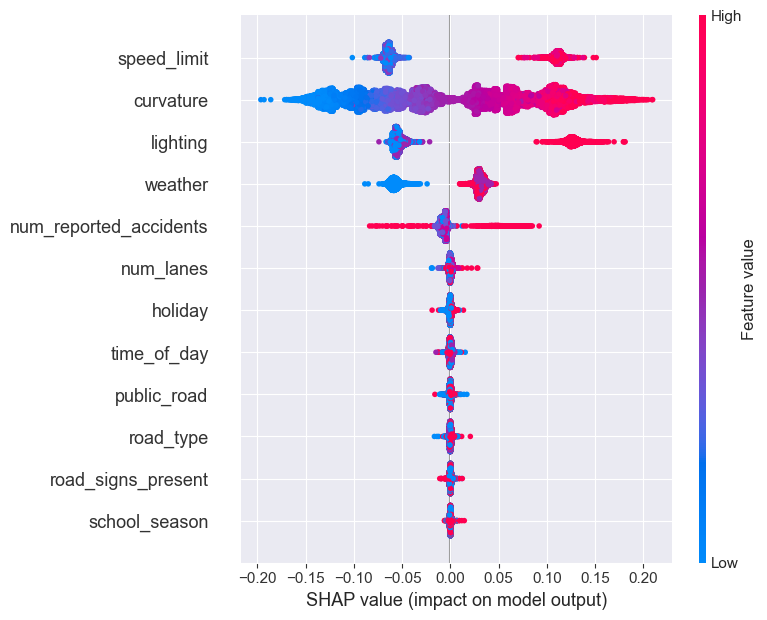

In [8]:
plot_importance(model, max_num_features=10)
plt.show()

sample_idx = np.random.choice(len(X_test), 2000, replace=False)
X_sample = X_test.iloc[sample_idx]

explainer = shap.Explainer(model)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)